<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Codealong Exploring SVMs Using Sklearn

_Authors: Joseph Nelson (DC), Justin Pounders_

---

In [1]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, linear_model, datasets
from sklearn.model_selection import cross_val_score

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Introduction to SVM

Support Vector Machines (SVMs) are *statistical models* used for **classification**.

---

Review:
- What is classification?
- What other classification models have you seen?

---

### How to Think about SVM

- The *geometric intuition* of SVMs is easier to grasp than the
- *mathematical constructs* needed to make it work


# Linear Separability

SVMs work really well for data in which the classes are *linearly separable*.


![fit](../assets/linear_separability_vs_not.png)


## Maximum-Margin Estimator

If classes are linearly seperable, SVM finds the *hyperplane* that sepearates the classess with *maximum margin*.

![fit](../assets/Margin.png)

**Why maximize the margin?**

- SVM solves for a decision boundary that should minimize the generalization error.
- Observations near the decision boundary are the most "ambiguous"
- SVM defines it's fit using the most ambiguous points

![fit](../assets/linear_sep_support_vecs_math.png)

### What if data are not linearly seperable?

- Still want to minimize $\|w\|$ (maximize margin)
- Would also like to minimize a *loss function* that penalizes points for being on the "wrong side"

We can use the *hinge loss function*:

$$
\begin{align}
\text{hinge loss} &= \sum_{i=1}^n \max\left[ 0, 1-y_i(w^Tx_i+b)\right] \\
&= \begin{cases}
0 & \text{if } x \text{ outside or on margin} \\ > 0 & \text{if } x \text{ within margin}
\end{cases}
\end{align}
$$

*Hinge loss penalizes misclassified points!*

Put "simply," we want to minimize

$$ C \times \left[ \text{hinge loss} \right] + \left[ \frac{1}{\text{margin width}} \right]$$

where $C$ is a hyperparameter.  We can rewrite this slightly to see it as

$$ \left[ \text{hinge loss} \right] + \frac{1}{C} \left[ \frac{1}{\text{margin width}} \right]$$

$$\sum_{i=1}^N \max\left(0, 1 - y_i(w^T x_i + b)\right) +  \frac{1}{C} ||w||^2$$

i.e., loss + 1/C * regularization (c.f. Ridge!)



> *Takeaway*: **Bias/variance trade-off** is handled via the hyperparameter $C$
>
> - Large $C \rightarrow$ narrow margin, less tolerant of misclassification, tends toward high variance
> - Small $C \rightarrow$ wider margin, more tolerant of misclassification, tends toward high bias


In [2]:
from ipywidgets import *
from IPython.display import display
import imp
plotter = imp.load_source('plotter', '../code/svm_plotter.py')
from plotter import SVMPlotter

svm_plotter = SVMPlotter()
svm_plotter.initialize_data(class_n=20)
svm_plotter.svm_interact()

interactive(children=(FloatSlider(value=-1.5, continuous_update=False, description='log C:', max=6.0, min=-6.0…

## What if your data are not separable?

Like, no where *close* to linearly separable?  **We can use something called the "kernel trick."

> Data that is not linearly sepearable in its default space may become linearly seperable in a higher dimensiosnal space.


![fit](../assets/kernel_trick.png)


In [3]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/9NrALgHFwTo" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


**Kernel choices** (in `sklearn`):

- Linear
- Polynomial
- Gaussian, a.k.a. Radial Basis Functions (RBF)

![fit](../assets/nonlinear-1.png)

![fit](../assets/nonlinear-2.png)


## Example: Digit Classification

### 1. Load the handwritten digits dataset.

In [4]:
# new dataset, handwritten digits!
digits = datasets.load_digits()
digits.data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [5]:
len(digits.data)      # 1,797 observations

1797

In [6]:
len(digits.data[0])   # 8 x 8 pixel image

64

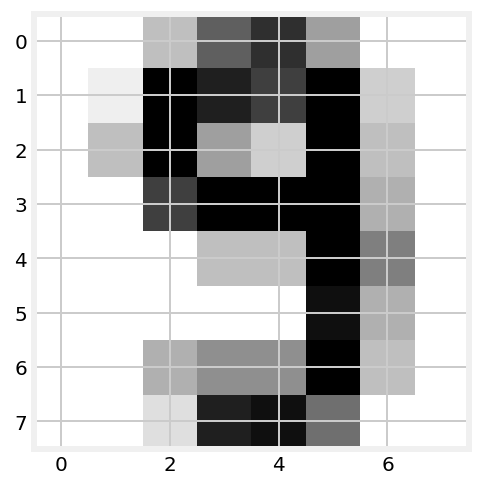

In [7]:
# the number 9
plt.imshow(digits.images[-5], cmap=plt.cm.gray_r, interpolation='nearest')

In [8]:
digits.target[-5]# 9

9

In [9]:
digits_X, digits_y = digits.data, digits.target

In [10]:
digits_X.shape

(1797, 64)

### 2. Cross-validate a logistic regression on the data.

In [11]:
# What if we just use logistic regression without doing anything?
logistic = linear_model.LogisticRegression()
cross_val_score(logistic, digits_X, digits_y, cv=5, scoring='accuracy').mean()
# OK not bad!!!

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.9137650882079852

### 3. Cross-validate a SVM on the data.

In [12]:
# Let's try a SVM
clf = svm.SVC()
print(cross_val_score(clf, digits_X, digits_y, cv=5, scoring='accuracy').mean())

# OOF, we even lost to the logistic regression....
# hmm we know that this defaults to the Gaussian (aka radial basis function)
# let's try something else
clf = svm.SVC(kernel='linear')
print(cross_val_score(clf, digits_X, digits_y, cv=5, scoring='accuracy').mean())

0.9632838130609718
0.9476973073351903


## Gaussian SVM has two parameters, gamma and C

---

### gamma

Intuitively, the gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. 

The higher the value of gamma, the more it will try to exactly fit the training data set. Will cause over-fitting problem.
- small gamma: the model is constrained, can under-fit!  high bias and low variance.
- big gamma: Tries to capture the shape too well: can over-fit!  low bias and high variance.


### C

Penalty parameter of the error term. It controls the trade off between smooth decision boundary and classifying the training points correctly. C can be thought of as the parameter for the soft margin cost function, which controls the influence of each individual support vector

- small C: makes the decision surface smooth and simple, softer margin can under-fit! high bias and low variance.
- big C: selects more support vectors: can over-fit! harder margin. low bias and high variance.


### 4. Fit an SVM modifying the default gamma and C.

In [13]:
# note the scale of gamma and C
clf = svm.SVC(gamma=0.001, C=1)
cross_val_score(clf, digits_X, digits_y, cv=5, scoring='accuracy').mean()

0.9721866295264624

### 5. Gridsearch an optimal gamma with C=1.

In [14]:
%%time
# Warning SLOWWWWW
from sklearn.model_selection import GridSearchCV

clf = svm.SVC(C=1)
param_grid = {'gamma':np.logspace(-5, 2, 20)}

grid = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', verbose=1)
grid.fit(digits_X, digits_y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   38.1s finished


Wall time: 38.4 s


GridSearchCV(cv=5, estimator=SVC(C=1),
             param_grid={'gamma': array([1.00000000e-05, 2.33572147e-05, 5.45559478e-05, 1.27427499e-04,
       2.97635144e-04, 6.95192796e-04, 1.62377674e-03, 3.79269019e-03,
       8.85866790e-03, 2.06913808e-02, 4.83293024e-02, 1.12883789e-01,
       2.63665090e-01, 6.15848211e-01, 1.43844989e+00, 3.35981829e+00,
       7.84759970e+00, 1.83298071e+01, 4.28133240e+01, 1.00000000e+02])},
             scoring='accuracy', verbose=1)

In [15]:
# check the results of the grid search
grid_mean_scores = grid.cv_results_['mean_test_score']
grid_mean_scores

array([0.88538069, 0.91487465, 0.93379294, 0.9488208 , 0.95883627,
       0.96829155, 0.96996286, 0.94103064, 0.72404364, 0.272736  ,
       0.1135376 , 0.10239554, 0.10128134, 0.10128134, 0.13359331,
       0.10573816, 0.10128134, 0.10072423, 0.10072423, 0.10072423])

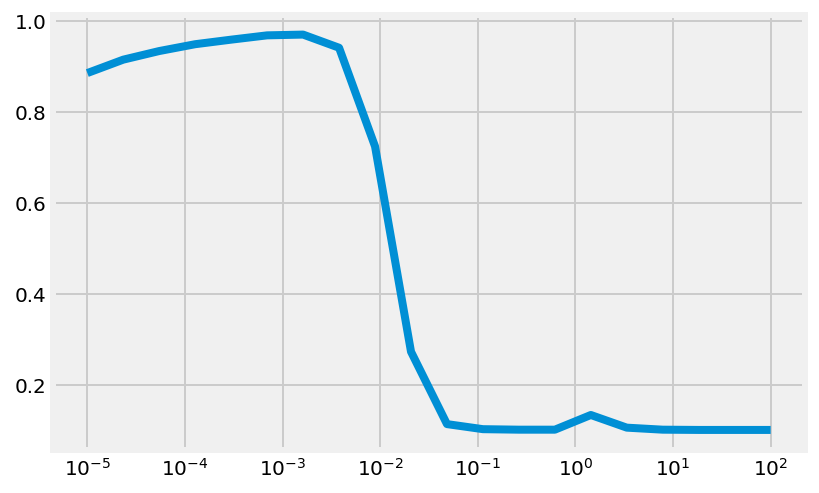

In [16]:
# plot the results
import matplotlib.pyplot as plt
plt.semilogx(param_grid['gamma'], grid_mean_scores)

In [17]:
grid.best_params_, grid.best_score_

({'gamma': 0.001623776739188721}, 0.9699628597957288)

### 6. Gridsearch the optimal C, gamma, and kernel.

In [18]:
# Warning SUPER MEGAAA SLOWWWWW
from sklearn.model_selection import GridSearchCV
clf = svm.SVC()

gamma_range = np.logspace(-5, 2, 10)
C_range = np.logspace(-3, 2, 10)
kernel_range = ['rbf', 'sigmoid', 'linear', 'poly']

param_grid = dict(gamma=gamma_range, C=C_range, kernel=kernel_range)

grid = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy', verbose=1)
grid.fit(digits_X, digits_y)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:  3.3min finished


GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02]),
                         'gamma': array([1.00000000e-05, 5.99484250e-05, 3.59381366e-04, 2.15443469e-03,
       1.29154967e-02, 7.74263683e-02, 4.64158883e-01, 2.78255940e+00,
       1.66810054e+01, 1.00000000e+02]),
                         'kernel': ['rbf', 'sigmoid', 'linear', 'poly']},
             scoring='accuracy', verbose=1)

In [19]:
# check the results of the grid search
print(grid.best_params_)
print(grid.best_score_)

{'C': 7.742636826811277, 'gamma': 0.00035938136638046257, 'kernel': 'rbf'}
0.9721758486366165


In [20]:
best_svm = grid.best_estimator_

### 7. Import the iris dataset.

In [21]:
# import some data to play with
iris = datasets.load_iris()
iris_X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
iris_y = iris.target

### 8. Cross-validate a default logistic regression and default SVM on the iris data.

In [22]:
# Start with logistic Regression
logistic = linear_model.LogisticRegression()
print(cross_val_score(logistic, iris_X, iris_y, cv=5, scoring='accuracy').mean())


# Let's try a SVM
clf = svm.SVC()
print(cross_val_score(clf, iris_X, iris_y, cv=5, scoring='accuracy').mean())

0.8133333333333332
0.82


---

## Pros and Cons of SVMs

*Pros*

- Exceptional perfomance (historically widely used)
- Robust to outliers
- Effective in high dimensional data
- Can work with non-linearities
- Fast to compute even on non-linear (kernel trick)
- Low risk of overfitting

*Cons*

- Blackbox
- Can be slow on large datasets


## When to use SVM vs. Logistic Regression

*(Advice from Andrew Ng)*

- **If there are more feature than training samples:**
    Use logistic regression or SVM without a kernel ("linear kernel")
- **If there are about 10 times as many samples as features:**
    Use SVM with a Gaussian kernel  
- **If there are many more training samples than features:**
    Spend time feature engineering, then use logistic regression or SVM without a kernel


## Additional Resources

- [For a really great resource check out these slides (some of which are cannabalized in this lecture).](http://www.robots.ox.ac.uk/~az/lectures/ml/lect2.pdf)
- [This website is also a great resource, on a slightly more technical level.](http://nlp.stanford.edu/IR-book/html/htmledition/support-vector-machines-the-linearly-separable-case-1.html)
- SVM docs on [SKLearn](http://scikit-learn.org/stable/modules/svm.html)
- Iris example on [SKLearn](http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html#example-svm-plot-iris-py)
- Hyperplane walkthrough on [SKLearn](http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html#example-svm-plot-separating-hyperplane-py)
- A comprehensive [user guide](http://pyml.sourceforge.net/doc/howto.pdf) to SVM. My fav!
- A [blog post tutorial](http://www.svm-tutorial.com/2014/11/svm-understanding-math-part-2/) of understanding the linear algebra behind SVM hyperplanes. Check [part 3](http://www.svm-tutorial.com/2015/06/svm-understanding-math-part-3/) of this blog on finding the optimal hyperplane
- This [Quora discussion](https://www.quora.com/How-do-you-teach-Support-Vector-Machine-to-a-beginner-in-Machine-Learning) includes a high-level overview plus a [20min video](https://www.youtube.com/watch?v=aDbsJ_S3tIA) walking through the core "need-to-knows"
- A [slideshow introduction](http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf) to the optimization considerations of SVM
- A second [slideshow overview from UCF](http://www.cs.ucf.edu/courses/cap6412/fall2009/papers/Berwick2003.pdf) on the highnotes of SVM
- Andrew Ng's [notes](http://cs229.stanford.edu/notes/cs229-notes3.pdf) on SVM from CS 229
- A [FULL LECTURE](https://www.youtube.com/watch?v=eHsErlPJWUU) (1hr+) from one of my fav lecturers (Dr Yasser) on SVM. He does a followup on [kernel tricks](https://www.youtube.com/watch?v=XUj5JbQihlU) too
- A [FULL LECTURE](https://www.youtube.com/watch?v=_PwhiWxHK8o) (50min) (from MIT Opencoursewar)
- An infamous [paper](https://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf) (cited 7000+ times!) on why SVM is a great text classifier
- An [advanced discussion](http://www.icml-2011.org/papers/386_icmlpaper.pdf) of SVMs as probabilistic models


### 9. [Bonus] Compare three SVMs with different kernels on the iris data visually.
- Gaussian
- Linear
- Poly of degree 3

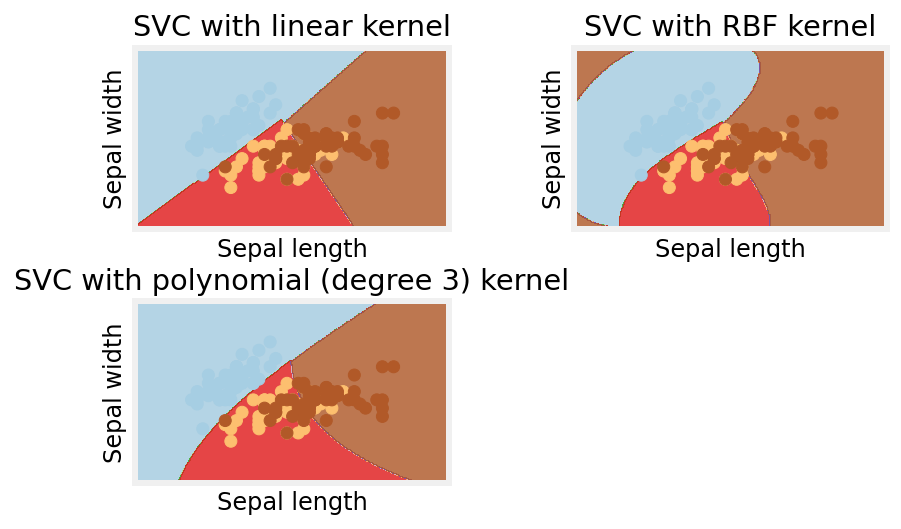

In [23]:
C = 1.0  # SVM regularization parameter
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(iris_X, iris_y)  # default kernel
svc = svm.SVC(kernel='linear', C=C).fit(iris_X, iris_y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(iris_X, iris_y)

# create a mesh to plot in
x_min, x_max = iris_X[:, 0].min() - 1, iris_X[:, 0].max() + 1
y_min, y_max = iris_X[:, 1].min() - 1, iris_X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02),
                     np.arange(y_min, y_max, .02))

# title for the plots
titles = ['SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']

for i, clf in enumerate((svc, rbf_svc, poly_svc)):
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    # Plot also the training points
    plt.scatter(iris_X[:, 0], iris_X[:, 1], c=iris_y, cmap=plt.cm.Paired)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])
plt.show()

### 10. [Bonus] Compare SVM kernels visually on fake data using sklearn's `make_circles`.

Load `make_circles` from here:
```python
from sklearn.datasets import make_circles
```

Compare the linear, rbf, and poly kernels.

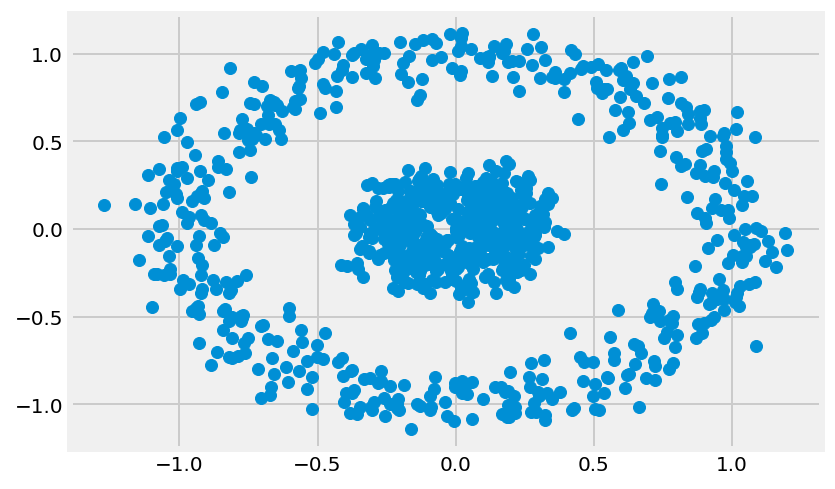

In [24]:
from sklearn.datasets import make_circles
circles_X, circles_y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)
plt.scatter(circles_X[:,0], circles_X[:,1])

In [25]:
# let's try to predict them without graphs
logreg = LogisticRegression()
print(cross_val_score(logreg, circles_X, circles_y, cv=5, scoring='accuracy').mean())

svc = svm.SVC(kernel = 'linear')        # I like lines
print(cross_val_score(clf, circles_X, circles_y, cv=5, scoring='accuracy').mean(), "i like lines")


poly_svc = svm.SVC(kernel = 'poly', degree = 3)        # I like 3rd degree polys
print(cross_val_score(clf, circles_X, circles_y, cv=5, scoring='accuracy').mean(), "i like 3rd degree polynomials")

rbf_svc = svm.SVC(kernel = 'rbf')           # I like circles
print(cross_val_score(clf, circles_X, circles_y, cv=5, scoring='accuracy').mean(), "i like circles")


0.489
0.624 i like lines
0.624 i like 3rd degree polynomials
0.624 i like circles


In [26]:
# the radial basis function fake projects the data into higher dimensions
# that accompany circles well

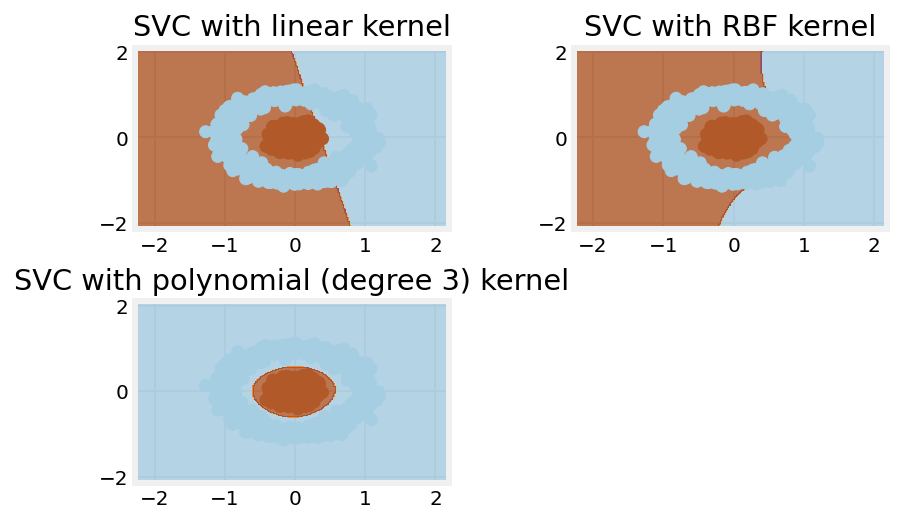

In [27]:
svc.fit(circles_X, circles_y)
poly_svc.fit(circles_X, circles_y)
rbf_svc.fit(circles_X, circles_y)

# create a mesh to plot in
x_min, x_max = circles_X[:, 0].min() - 1, circles_X[:, 0].max() + 1
y_min, y_max = circles_X[:, 1].min() - 1, circles_X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02),
                     np.arange(y_min, y_max, .02))

# title for the plots
titles = ['SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']

for i, clf in enumerate((svc, poly_svc, rbf_svc)):
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    
    # Plot also the training points
    plt.scatter(circles_X[:, 0], circles_X[:, 1], c=circles_y, cmap=plt.cm.Paired)
    plt.title(titles[i])
plt.show()

# a real thing of beauty

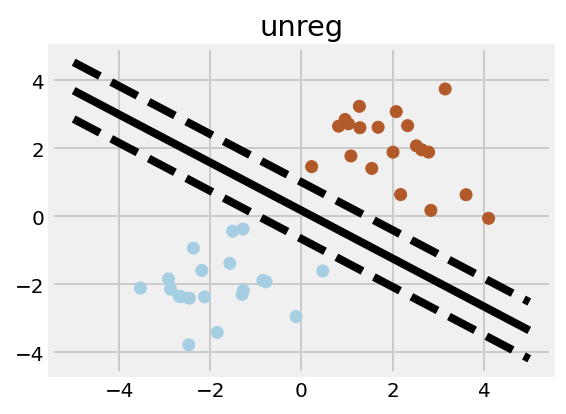

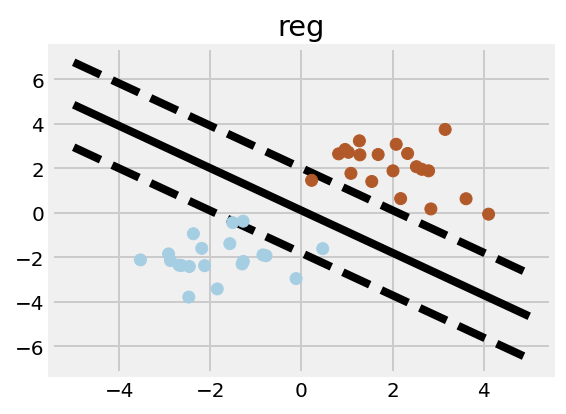

In [28]:
# Visualizing different C

X = np.r_[np.random.randn(20, 2) - [2, 2], np.random.randn(20, 2) + [2, 2]]
Y = [0] * 20 + [1] * 20

# figure number
fignum = 1

# fit the model
for name, penalty in (('unreg', 1), ('reg', 0.05)):

    clf = svm.SVC(kernel='linear', C=penalty)
    clf.fit(X, Y)

    # get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-5, 5)
    yy = a * xx - (clf.intercept_[0]) / w[1]

    # plot the parallels to the separating hyperplane that pass through the
    # support vectors
    margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
    yy_down = yy + a * margin
    yy_up = yy - a * margin

    # plot the line, the points, and the nearest vectors to the plane
    plt.figure(fignum, figsize=(4, 3))
    plt.clf()
    plt.plot(xx, yy, 'k-')
    plt.plot(xx, yy_down, 'k--')
    plt.plot(xx, yy_up, 'k--')

    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
                facecolors='none', zorder=10)
    plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired)

    plt.axis('tight')
    plt.title(name)

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])

    fignum = fignum + 1

plt.show()